# Introduzione

Benvenuti a questo tutorial dedicato all'analisi dei dati degli scacchi. Ho scelto di esplorare questo affascinante mondo in quanto, dopo un certo numero di mosse, molte partite di scacchi non sono mai state giocate. Questo ci offre un'enorme quantità di dati da esaminare e analizzare.

Per condurre la nostra analisi, faremo uso delle APIs messe a disposizione da [lichess.org](https://lichess.org/). È importante notare che molte di queste APIs sono accessibili gratuitamente, ma alcune richiedono l'utilizzo di una chiave API. Fortunatamente, ottenere una chiave API è un processo semplice e può essere completato dopo essersi registrati sul sito.

In questo tutorial, ci concentreremo su diverse aspetti dell'analisi dei dati delle partite di scacchi, concentrandoci in particolare sulle aperture e sull'analisi del punteggio delle partite. Esploreremo come ottenere informazioni dettagliate sulle aperture più popolari e cercheremo una soglia di punteggio a partire dal quale un giocatore ha praticamente vinto la partita. Attraverso l'utilizzo delle API di lichess.org, avremo accesso a dati in tempo reale e potremo analizzare le tendenze e i modelli emergenti nelle partite di scacchi.

# Una breve introduzione alle APIs

Prima di iniziare la nostra esplorazione, è fondamentale comprendere come accedere alle preziose risorse messe a disposizione da lichess.org attraverso le loro APIs. La documentazione completa di tutte le APIs è accessibile al seguente link: [Documentazione Lichess.org](https://lichess.org/api)

Per agevolare la navigazione e la comprensione delle diverse APIs disponibili, il sito desktop è strutturato in tre sezioni principali:
- Tendina con le APIs (divise per categoria): Troverete un menu a tendina organizzato per categorie, semplificando la ricerca delle APIs specifiche che desiderate esplorare. Da analisi di partite a statistiche dei giocatori, l'ampia gamma di categorie vi consentirà di trovare l'API adatta alle vostre esigenze.
- Documentazione dell'API selezionata: Una volta che avrete scelto un'API di vostro interesse dalla tendina, la documentazione dettagliata associata sarà immediatamente accessibile. Questo vi fornirà informazioni cruciali su come formulare le richieste, i parametri accettati e i dati restituiti.
- Esempio dell'API selezionata: Per rendere il processo ancora più chiaro, ogni API è corredato da un esempio pratico che illustra come effettuare una richiesta e interpretare la risposta. Questo è particolarmente utile per comprendere l'applicazione pratica delle informazioni fornite dalla documentazione.



### Autorizzazione

Per le APIs che richiedono autenticazione, la piattaforma lichess.org si affida al protocollo OAuth 2.0. OAuth 2.0 è un framework standardizzato per consentire a terze parti di accedere a risorse utente senza dover condividere le credenziali direttamente.


### Generazione API Key

Per generare l'API key ho effettuato i seguenti passaggi:
- Registrazione alla piattaforma [link](https://lichess.org/signup)
![](./img/registrazione.png)
- Login alla piattaforma [link](https://lichess.org/signup)
![](./img/login.png)
- Generazione API key [link](https://lichess.org/account/oauth/token)
![](./img/Token1.png)
![](./img/Token2.png)
![](./img/Token3.png)
![](./img/Token4.png)

# Linguaggio usato

Nel corso di questo tutorial, ci avventureremo nell'analisi dei dati degli scacchi utilizzando il linguaggio di programmazione Python. Python è una scelta eccellente per questo scopo grazie alla sua sintassi chiara, alle numerose librerie disponibili e alla vasta comunità di sviluppatori che lo supporta.

### Stile di programmazione

Nel corso di questo tutorial, adotteremo uno stile di programmazione incentrato sulla modularità e riusabilità del codice. Questa pratica è fondamentale per garantire una base solida, facilitare la manutenzione e consentire il riuso efficiente delle porzioni di codice 😃🚀






##### Sperando che l'introduzione sia stata chiara e abbia gettato le basi solide per il nostro progetto, passiamo ora alla parte divertente: scrivere il codice 🥳

# Classi e funzioni utili

In [1]:
# Tutte le librerie usate
import requests
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time
import re

In [2]:
class HTTPRequest:
    """
    Classe per effettuare richieste HTTP con supporto per token OAuth.

    Args:
        token_oauth (str): Il token OAuth da utilizzare per l'autenticazione.

    Methods:
        perform_request(method, url, params=None, data=None):
            Effettua una richiesta HTTP utilizzando il metodo specificato.

        download_file(url, local_filename):
            Scarica un file da un URL e lo salva localmente.

    """

    def __init__(self, token_oauth=None):
        """
        Inizializza un oggetto HTTPRequest con il token OAuth specificato.

        Args:
            token_oauth (str): Il token OAuth da utilizzare per l'autenticazione.
        """
        self.token_oauth = token_oauth

    def _add_authorization_header(self, headers):
        """
        Aggiunge l'intestazione di autorizzazione con il token OAuth agli headers.

        Args:
            headers (dict): Gli headers della richiesta HTTP.

        Returns:
            dict: Gli headers aggiornati.
        """
        if self.token_oauth:
            headers["Authorization"] = f"Bearer {self.token_oauth}"
        return headers

    def _perform_request(self, method, url, params=None, data=None):
        """
        Effettua una richiesta HTTP utilizzando il metodo specificato.

        Args:
            method (str): Il metodo HTTP da utilizzare ("GET" o "POST").
            url (str): L'URL della richiesta.
            params (dict, optional): I parametri della richiesta.
            data (dict, optional): I dati JSON della richiesta.

        Returns:
            dict or None: I dati JSON della risposta, se la richiesta ha successo, altrimenti None.
        """
        try:
            headers = {"Content-Type": "application/json"}
            headers = self._add_authorization_header(headers)

            if method == "GET":
                response = requests.get(url, params=params, headers=headers)
            elif method == "POST":
                response = requests.post(url, params=params, json=data, headers=headers)
            else:
                raise ValueError("Metodo non supportato")

            if response.status_code == 200:
                return response.json()
            else:
                print(f"Errore nella richiesta. Codice di stato: {response.status_code}")
                return None

        except requests.exceptions.RequestException as e:
            print(f"Errore durante la richiesta: {e}")
            return None

    def perform_request(self, method, url, params=None, data=None):
        """
        Effettua una richiesta HTTP utilizzando il metodo specificato.

        Args:
            method (str): Il metodo HTTP da utilizzare ("GET" o "POST").
            url (str): L'URL della richiesta.
            params (dict, optional): I parametri della richiesta.
            data (dict, optional): I dati JSON della richiesta.

        Returns:
            dict or None: I dati JSON della risposta, se la richiesta ha successo, altrimenti None.
        """
        return self._perform_request(method, url, params=params, data=data)

    def download_file(self, url, local_filename):
        """
        Scarica un file da un URL e lo salva localmente.

        Args:
            url (str): L'URL del file da scaricare.
            local_filename (str): Il percorso locale del file in cui salvare il download.

        Returns:
            bool: True se il download ha avuto successo, False altrimenti.
        """
        try:
            headers = self._add_authorization_header({})
            response = requests.get(url, headers=headers, stream=True)

            if response.status_code == 200:
                with open(local_filename, 'wb') as file:
                    for chunk in response.iter_content(chunk_size=128):
                        file.write(chunk)
                return True
            else:
                print(f"Errore nel download. Codice di stato: {response.status_code}")
                return False

        except requests.exceptions.RequestException as e:
            print(f"Errore durante il download: {e}")
            return False

In [3]:
class Plotter:
    def __init__(self):
        pass

    def plot_2d_histogram(self, data, title='', xlabel='', ylabel='', color = 'skyblue', width=1):
        """
        Crea un istogramma bidimensionale.

        Args:
            data (list): Lista contenente i dati da visualizzare. [x, y]
            title (str): Titolo del grafico.
            xlabel (str): Etichetta dell'asse x.
            ylabel (str): Etichetta dell'asse y.
            color (str): Colore delle barre dell'istogramma.

        Returns:
            None
        """
        x, y = data
        plt.figure(figsize=(10, 6))
        plt.bar(x, y, color=color, width=width)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90, ha='right')
        plt.show()
    
    def plot_3d_histogram(self, data, title='', xlabel='', ylabel='', zlabel='', highlight_categories=None):
        """
        Crea un istogramma tridimensionale.

        Args:
            data (dict): Dizionario contenente i dati da visualizzare. {category: {opening: count}}
            title (str): Titolo del grafico.
            xlabel (str): Etichetta dell'asse x.
            ylabel (str): Etichetta dell'asse y.
            zlabel (str): Etichetta dell'asse z.
            highlight_categories (list): Lista delle categorie da evidenziare.

        Returns:
            None
        """
        fig = plt.figure(figsize=(20, 20))  # Adjust the figsize as needed
        ax = fig.add_subplot(111, projection='3d')
        color_for_category_highlighted = {}
        categories = list(data.keys())
        openings = sorted(set(opening for category in data.values() for opening in category.keys()))

        default_colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Change the colormap as needed

        for i, category in enumerate(categories):
            counts = np.array([data[category].get(opening, 0) for opening in openings])
            xpos = np.arange(len(openings))
            ypos = i
            zpos = np.zeros(len(openings))
            dx = dy = 0.8
            dz = counts

            color = 1 - default_colors[i]
            alpha = 0.6

            if highlight_categories is not None:
                
                if category in highlight_categories:
                    color = (color[0], color[1], color[2])  # Highlighted category
                    alpha = 0.8
                else:
                    color = (color[0], color[1], color[2])  # Other categories
                    alpha = 0.2
                color_for_category_highlighted[category] = color
            ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha=alpha, color=color, label=category)

        plt.title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_zlabel(zlabel)
        ax.set_xticks(np.arange(len(openings)))
        ax.set_xticklabels(openings, rotation=90)
        ax.set_yticks(np.arange(len(categories)))
        ax.set_yticklabels(categories)

        plt.show()
        
        if highlight_categories == None:
            return
        
        for category in highlight_categories:
            self.plot_2d_histogram([data[category].keys(), data[category].values()], title=f"{category}", color=color_for_category_highlighted[category])
            
    def plot_functions(self, x_values_list, y_values_list, labels=None, xlabel='', ylabel='', title='Multiple Functions Plot', figsize=(10, 6)):
        """
        Crea un grafico per più funzioni.

        Parameters:
        - x_values_list: Lista di array contenenti i valori x per ciascuna funzione.
        - y_values_list: Lista di array contenenti i valori y per ciascuna funzione.
        - labels: Lista di etichette per ciascuna funzione.
        - xlabel: Etichetta dell'asse x.
        - ylabel: Etichetta dell'asse y.
        - title: Titolo del grafico.
        - figsize: Tupla (larghezza, altezza) specificando le dimensioni della figura.
        """
        plt.figure(figsize=figsize)

        if labels is not None:
            for x_values, y_values, label in zip(x_values_list, y_values_list, labels):
                plt.plot(x_values, y_values, label=label)
        else:
            for x_values, y_values in zip(x_values_list, y_values_list):
                plt.plot(x_values, y_values)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)

        if labels is not None:
            plt.legend()

        plt.show()


In [4]:
class Game:
    """
    Classe per la rappresentazione e l'analisi di partite di scacchi tramite stringhe di gioco in formato PGN.

    Parametri:
    - game_string (str): Una stringa di gioco in formato PGN.

    Metodi:
    - extract_moves(): Estrae le mosse della partita dalla stringa di gioco.
    - get_winner(): Restituisce il vincitore della partita ('White', 'Black', 'Draw') o None se non disponibile.
    - get_evals(): Restituisce una lista di valutazioni numeriche delle mosse della partita.
    - get_game_id(): Restituisce l'ID della partita estratto dalla URL di Lichess, o None se non disponibile.
    """

    def __init__(self, game_string):
        """
        Inizializza un oggetto Game con la stringa di gioco fornita.
        """
        self.game_string = game_string

    def extract_moves(self):
        """
        Estrae le mosse della partita dalla stringa di gioco.

        Restituisce:
        - list: Una lista di mosse rappresentate come stringhe.
        """
        move_pattern = re.compile(r'\d+\.\s(\S+)')
        moves = move_pattern.findall(self.game_string)
        return moves

    def get_winner(self):
        """
        Restituisce il vincitore della partita ('White', 'Black', 'Draw') o None se non disponibile.

        Restituisce:
        - str or None: Il vincitore della partita o None se non disponibile.
        """
        result_pattern = re.compile(r'\[Result "(.*?)"\]')
        result_match = result_pattern.search(self.game_string)
        if result_match:
            result = result_match.group(1)
            if result == '1-0':
                return 'White'
            elif result == '0-1':
                return 'Black'
            elif result == '1/2-1/2':
                return 'Draw'
        return None

    def get_evals(self):
        """
        Restituisce una lista di valutazioni numeriche delle mosse della partita.

        Restituisce:
        - list: Una lista di valutazioni numeriche.
        """
        eval_pattern = re.compile(r'\[%eval (.*?)\]')
        evals = eval_pattern.findall(self.game_string)
        clean_evals = [float(eval_) for eval_ in evals if not eval_.startswith("#")]
        return clean_evals
    
    def get_game_id(self):
        """
        Restituisce l'ID della partita estratto dalla URL di Lichess, o None se non disponibile.

        Restituisce:
        - str or None: L'ID della partita o None se non disponibile.
        """
        site_pattern = re.compile(r'\[Site "(https://lichess.org/.*?)"]')
        site_match = site_pattern.search(self.game_string)
        if site_match:
            site_url = site_match.group(1)
            # Estrae l'ID della partita dalla URL
            game_id = site_url.split("/")[-1]
            return game_id
        return None


In [5]:
# funzione per stampare le risposte delle richieste HTTP in modo chiaro
def print_json(response):
    if response is not None:
        print(json.dumps(response, indent=4, sort_keys=False))

        
# Restituisce un array in cui ciascun elemento ha il nome della chiave ripetuto tante 
# volte quanto è il suo valore.
def repeat_keys_as_array(input_dict):
    result_array = [key for key, value in input_dict.items() for _ in range(value)]
    return np.array(result_array)

In [6]:
# L'API Key non è scritta nel codice, essa è salvata in un file di configurazione esterno
from config import API_KEY

In [7]:
# Istanzio l'oggetto per effettuare le richieste HTTP
http_request = HTTPRequest(API_KEY)

# Un primo test delle API

Abbiamo investito un po' di tempo nella creazione delle classi, però ne è valsa la pena. Vediamo come ora il codice viene super veloce da scrivere 🚀

In [8]:
# provo ad effettuare una richiesta GET
response = http_request.perform_request("GET", "https://lichess.org/api/account")

print_json(response)

{
    "id": "simoneavelino",
    "username": "SimoneAvelino",
    "perfs": {
        "blitz": {
            "games": 0,
            "rating": 1500,
            "rd": 500,
            "prog": 0,
            "prov": true
        },
        "bullet": {
            "games": 0,
            "rating": 1500,
            "rd": 500,
            "prog": 0,
            "prov": true
        },
        "correspondence": {
            "games": 0,
            "rating": 1500,
            "rd": 500,
            "prog": 0,
            "prov": true
        },
        "classical": {
            "games": 0,
            "rating": 1500,
            "rd": 500,
            "prog": 0,
            "prov": true
        },
        "rapid": {
            "games": 2,
            "rating": 1031,
            "rd": 230,
            "prog": 0,
            "prov": true
        }
    },
    "createdAt": 1699986125994,
    "seenAt": 1703083696909,
    "playTime": {
        "total": 203,
        "tv": 0
    },
    "url": "ht

Faccio notare che grazia alle classi create in precedenza non abbiamo più bisogno di passare alcuna API_KEY in quanto ormai tutto il lavoro è delegato alla classe. VIVA L'INGEGNERIA DEL SOFTWARE🫶

# Analisi aperture più usate

L'obiettivo di questa analisi è esplorare le aperture più frequentemente utilizzate dai migliori giocatori di scacchi. La procedura comprende la raccolta e l'analisi dei dati sulle partite, differenziando le aperture sia in base alle categorie di partite che in generale.

In [9]:
# Otteniamo l'ID dei migliori giocatori per ogni categoria di gioco
response = http_request.perform_request("GET", "https://lichess.org/api/player")

# Estraiamo le categorie di gioco disponibili
categories = list(response.keys())

# Inizializziamo un dizionario per memorizzare gli ID dei migliori giocatori per ogni categoria
top_players_category = {category: [] for category in categories}

# Cicliamo attraverso le categorie di gioco
for category in categories:
    # Estraiamo gli ID dei migliori giocatori nella categoria corrente
    for player in response[category]:
        top_players_category[category].append(player['id'])

print_json(top_players_category)

            
    

{
    "bullet": [
        "azzaro25",
        "shadowking78",
        "muisback",
        "watneg",
        "vincentkeymer2004",
        "aaryan_varshney",
        "italianchessstar",
        "v_m",
        "anhghost24",
        "yulkaaa"
    ],
    "blitz": [
        "konevlad",
        "muisback",
        "athena-pallada",
        "yarebore",
        "chess_is_life23",
        "schaakams",
        "anythingbutaverage",
        "savakrasavavictory",
        "lintchevski_daniil",
        "ilqar_7474"
    ],
    "rapid": [
        "drvitman",
        "mysterious_expert",
        "tuzakli_egitim",
        "drawdenied_twitch",
        "siyay_25",
        "iakov98",
        "normal_one",
        "thecablebox",
        "matarez",
        "lion2006-45"
    ],
    "classical": [
        "homabiorkro",
        "plemsovhoz",
        "lord-universe31",
        "ojaijoao",
        "sharkfang",
        "lion2006-45",
        "sirromp",
        "kc6",
        "naytatel",
        "chesstheory64"
   

Di seguito fornisco tutte le funzioni che userò per analizzare le aperture. Si consiglia al lettore di vedere prima la funzione "retrieve_games_openings" in quanto è quella di più alto livello che fa capire in modo più chiaro ed usando astrazioni, ciò che stiamo facendo.

In [10]:
def games_ids(players, categories, games_type):
    """
    Otteniamo gli ID delle partite per i migliori giocatori nelle categorie specificate e per il tipo di partita dato.

    Args:
        players (dict): Dizionario contenente gli ID dei migliori giocatori per ogni categoria.
        categories (list): Lista delle categorie di gioco da analizzare.
        games_type (str): Tipo di partita da analizzare (ad esempio, "bullet", "blitz", "rapid", "classical").

    Returns:
        dict: Dizionario contenente gli ID delle partite per ogni categoria di gioco specificata.
    """

    # Inizializziamo un dizionario per memorizzare gli ID delle partite per ogni categoria
    top_games_category = {category: [] for category in categories}

    # Cicliamo attraverso le categorie di gioco
    for category in categories:
        # Estraiamo gli ID dei migliori giocatori nella categoria corrente
        category_players = players[category]
        
        # Cicliamo attraverso i giocatori nella categoria
        for player in category_players:
            # Costruiamo l'URL API per ottenere le partite del giocatore nella categoria e tipo specificati
            api_call = f"https://lichess.org/api/user/{player}/perf/" + category
            response = http_request.perform_request("GET", api_call)
            
            # Estraiamo gli ID delle partite dal risultato della chiamata API
            top_games_category[category].extend(game['gameId'] for game in response['stat'][games_type]['results'])
        
        print(f"{category} category analyzed")

    return top_games_category


In [11]:
def download_games(game_ids_by_category, categories):
    """
    Effettuiamo il download delle partite per ogni categoria specificata.

    Args:
        game_ids_by_category (dict): Dizionario contenente gli ID delle partite per ogni categoria.
        categories (list): Lista delle categorie di gioco da cui scaricare le partite.
    """

    # URL base per il download delle partite
    base_api_url = "https://lichess.org/game/export/"
    
    # Cicliamo attraverso le categorie di gioco
    for category in categories:
        print("Effettuiamo il download delle partite per la categoria", category)
        
        # Cicliamo attraverso gli ID delle partite nella categoria
        for game_id in game_ids_by_category[category]:
            # Costruiamo l'URL API per il download della partita
            api_call = f"{base_api_url}{game_id}"
            
            # Effettuiamo il download del file della partita e salviamolo localmente
            success = http_request.download_file(api_call, f"./games/{category}_{game_id}.txt")
            
            # Stampa un messaggio se il download ha avuto successo o è fallito
            if not success:
                print(f"Impossibile scaricare la partita {game_id}.")



In [12]:
def get_openings(top_games_category, categories):
    """
    Otteniamo le aperture utilizzate nelle partite di ciascuna categoria.

    Args:
        top_games_category (dict): Dizionario contenente gli ID delle partite per ogni categoria.
        categories (list): Lista delle categorie di gioco da analizzare.

    Returns:
        dict, list: Dizionario contenente le aperture per ogni categoria e la lista aggiornata delle categorie.
    """

    # Dizionario per memorizzare le aperture per ogni categoria
    category_openings = {category: [] for category in categories}

    # Cicliamo attraverso le categorie di gioco
    for category in categories:
        # Cicliamo attraverso gli ID delle partite nella categoria
        for gameId in top_games_category[category]:
            # Costruiamo il percorso del file della partita
            filename = f"./games/{category}_{gameId}.txt"

            # Verifichiamo se il file esiste
            if os.path.exists(filename):
                with open(filename, 'r') as file:
                    # Estraiamo la linea che contiene l'apertura dalla partita
                    opening_line = [line.strip() for line in file if line.startswith("[Opening")][0]
                    opening = opening_line[len("[Opening]") + 1: -2]

                    # Se una categoria non ha specificato l'apertura delle sue partite,
                    # rimuoviamo la categoria da quelle da analizzare
                    if opening == "?":
                        categories.remove(category)
                        category_openings.pop(category)
                        break

                    # Rimuoviamo una possibile variante dell'apertura
                    try:
                        opening = opening[: opening.index(':')]
                    except ValueError:
                        pass

                    # Aggiungiamo l'apertura al dizionario
                    category_openings[category].append(opening)
            else:
                print(f"File not found: {filename}")

    return category_openings, categories


In [13]:
def count_openings(openings_list_by_category):
    """
    Contiamo quante volte è avvenuta ciascuna apertura, sia per categoria che in generale.

    Args:
        openings_list_by_category (dict): Dizionario contenente le aperture utilizzate per ogni categoria.

    Returns:
        dict, dict: Dizionario contenente il conteggio delle aperture per ogni categoria e conteggio generale delle aperture.
    """

    # Creiamo un dizionario per contare quante volte è avvenuta un'apertura per ogni categoria
    category_openings_count = {category: {opening: 0 for opening in set(openings_list)} for category, openings_list in openings_list_by_category.items()}

    # Creiamo un dizionario per contare quante volte è avvenuta un'apertura in generale
    openings_count = {opening: 0 for openings_list in openings_list_by_category.values() for opening in openings_list}

    # Contiamo quante volte è stata usata ciascuna apertura
    for category, category_openings in openings_list_by_category.items():
        for opening in category_openings:
            category_openings_count[category][opening] += 1
            openings_count[opening] += 1
    
    return category_openings_count, openings_count


In [14]:
def retrieve_games_openings(players_by_category, categories, game_type):
    """
    Eseguiamo l'analisi delle aperture per un tipo specifico di partita.

    Args:
        players_by_category (dict): Dizionario contenente gli ID dei migliori giocatori per ogni categoria.
        categories (list): Lista delle categorie di gioco da analizzare.
        game_type (str): Tipo di partita da analizzare (ad esempio, "bullet", "blitz", "rapid", "classical").

    Returns:
        dict, dict: Dizionario contenente il conteggio delle aperture per ogni categoria e conteggio generale delle aperture.
    """

    print("Analizziamo", game_type, "mosse")
    print("Ottieni gli ID delle partite...")
    top_games_category = games_ids(players_by_category, categories, game_type)
    print("Scaricando le partite...")
    download_games(top_games_category, categories)
    print("Contiamo le aperture...")
    openings_list_by_category, categories = get_openings(top_games_category, categories)
    openings_count_by_category, openings_count = count_openings(openings_list_by_category)
    print(game_type, "analizzato")
    return openings_count_by_category, openings_count


In [15]:
# otteniamo tutte le aperture per le migliori partite
best_openings_by_category, best_openings = retrieve_games_openings(top_players_category, categories, "bestWins")

time.sleep(5) # aspettiamo 5 secondi sperando che il server non ci blocchi per eccesso di richieste 🤞

# otteniamo tutte le aperture per le peggiori partite
worst_openings_by_category, worst_openings = retrieve_games_openings(top_players_category, categories, "worstLosses")

Analizziamo bestWins mosse
Ottieni gli ID delle partite...
bullet category analyzed
blitz category analyzed
rapid category analyzed
classical category analyzed
ultraBullet category analyzed
crazyhouse category analyzed
chess960 category analyzed
kingOfTheHill category analyzed
threeCheck category analyzed
antichess category analyzed
atomic category analyzed
horde category analyzed
racingKings category analyzed
Scaricando le partite...
Effettuiamo il download delle partite per la categoria bullet
Effettuiamo il download delle partite per la categoria blitz
Effettuiamo il download delle partite per la categoria rapid
Effettuiamo il download delle partite per la categoria classical
Effettuiamo il download delle partite per la categoria ultraBullet
Effettuiamo il download delle partite per la categoria crazyhouse
Effettuiamo il download delle partite per la categoria chess960
Effettuiamo il download delle partite per la categoria kingOfTheHill
Effettuiamo il download delle partite per la c

Abbiamo acquisito i dati e notiamo che le aperture classificate come migliori e peggiori potrebbero non coincidere. Per risolvere questa discrepanza, procediamo considerando solo le aperture che sono presenti in entrambe le categorie.

In [16]:
# Consideriamo solo le aperture in comune fra le partite migliori e peggiori

# Lista delle aperture comuni
common_openings = np.array(list(set(best_openings.keys()) & set(worst_openings.keys())))

# Filtra le aperture nei dizionari mantenendo solo quelle comuni
best_openings_freq = np.array([best_openings[opening] for opening in common_openings])
worst_openings_freq = np.array([worst_openings[opening] for opening in common_openings])

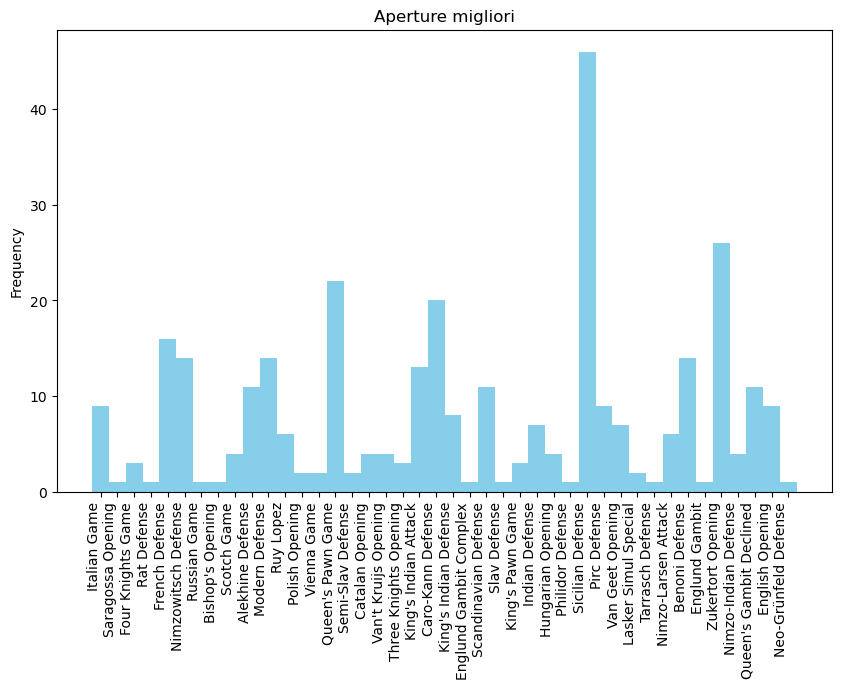

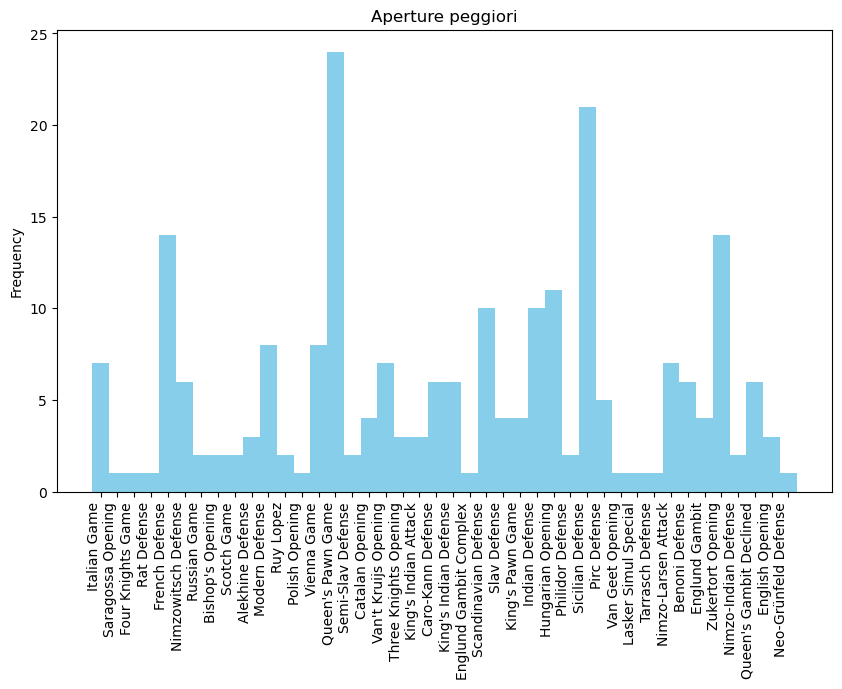

In [17]:
plotter = Plotter()

plotter.plot_2d_histogram([common_openings, best_openings_freq], title="Aperture migliori", ylabel="Frequency")
plotter.plot_2d_histogram([common_openings, worst_openings_freq], title="Aperture peggiori", ylabel="Frequency")

La frequenza non è sulla stessa scala di riferimento. Effettuiamo una normalizzazione.

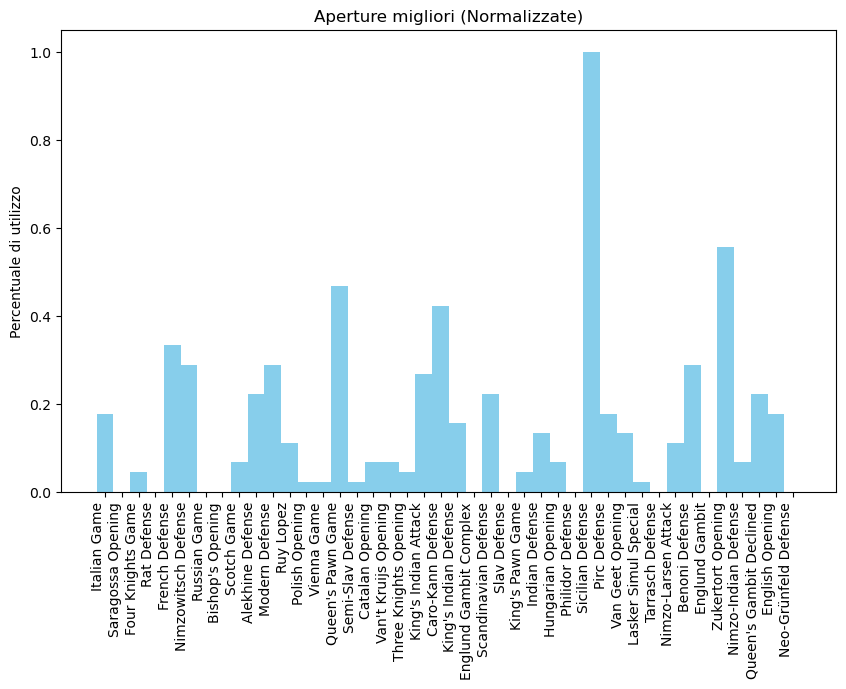

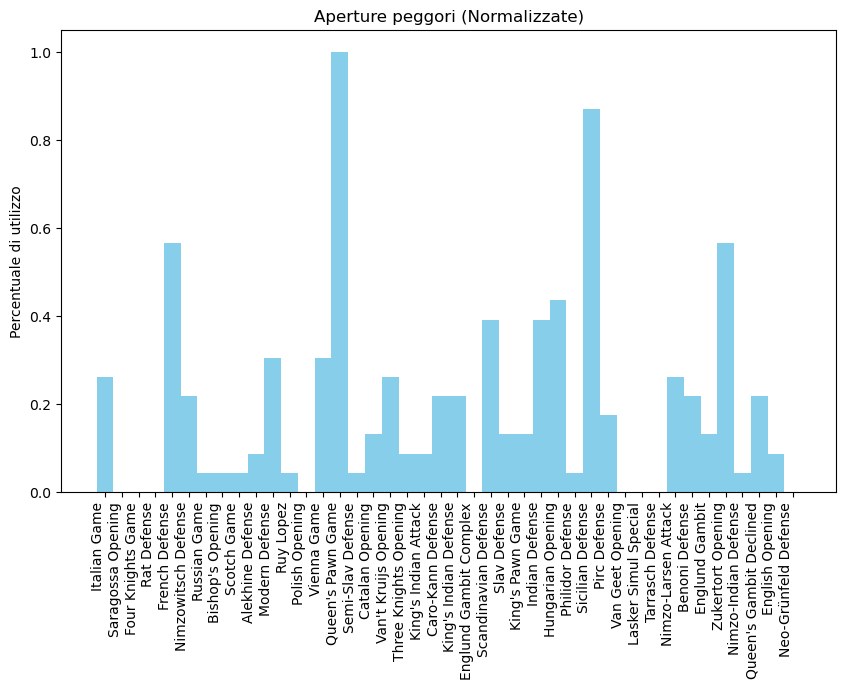

In [18]:
scores_array = np.vstack((best_openings_freq, worst_openings_freq)).T
scaler = MinMaxScaler()
normalized_freq = scaler.fit_transform(scores_array)
best_openings_freq, worst_openings_freq = normalized_freq[:, 0], normalized_freq[:, 1]

plotter.plot_2d_histogram([common_openings, best_openings_freq], title="Aperture migliori (Normalizzate)", ylabel="Percentuale di utilizzo")
plotter.plot_2d_histogram([common_openings, worst_openings_freq], title="Aperture peggori (Normalizzate)", ylabel="Percentuale di utilizzo")



A seguito dell'applicazione della normalizzazione dei dati mediante la tecnica di MinMax Scaling, abbiamo ottenuto una rappresentazione uniforme delle aperture, mantenendo intatte le proporzioni originali dei dati. Tale procedimento ci consente di confrontare e analizzare le frequenze delle aperture su una scala di riferimento comune, garantendo una visualizzazione coerente e significativa delle tendenze emergenti nei giochi migliori e peggiori. In questo modo, possiamo esplorare in maniera accurata le dinamiche delle aperture senza distorsioni dovute a differenze nelle scale di valori.

Una componente intrigante dell'analisi è comprendere quali aperture risultino più vantaggiose o svantaggiose nell'ambito delle partite di scacchi. Questo ci permette di identificare le strategie di apertura che possono portare a risultati più favorevoli o meno favorevoli. L'utilizzo di aperture che dimostrano maggiore efficacia può rappresentare una scelta tattica saggia.

Le aperture che risultano essere efficaci in partite di successo e poco utilizzate in partite meno favorevoli sono considerate aperture di successo. Il punteggio di convenienza sarà derivato da questa osservazione.

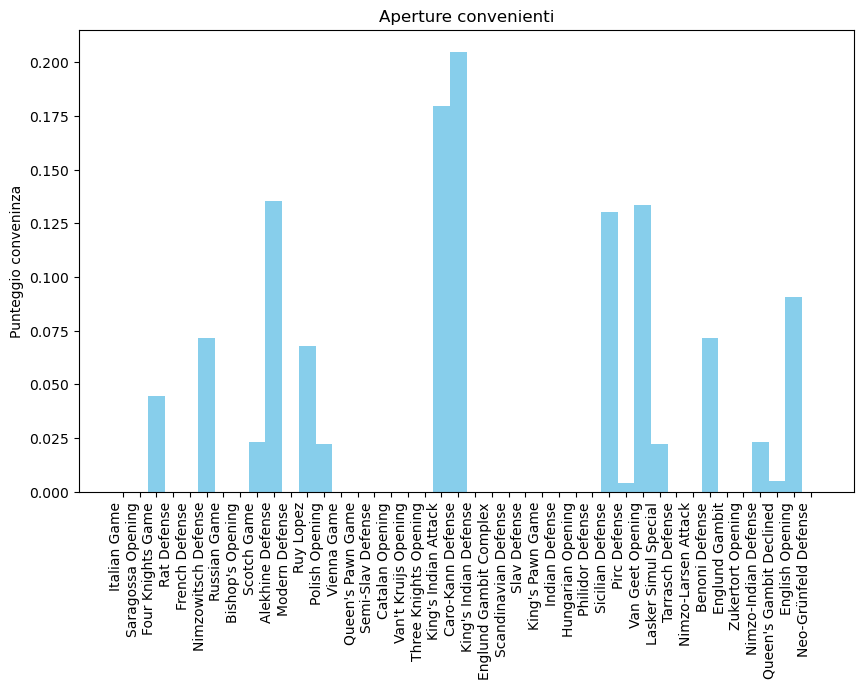

Migliori 3 aperture:
 ['Caro-Kann Defense' "King's Indian Attack" 'Alekhine Defense']


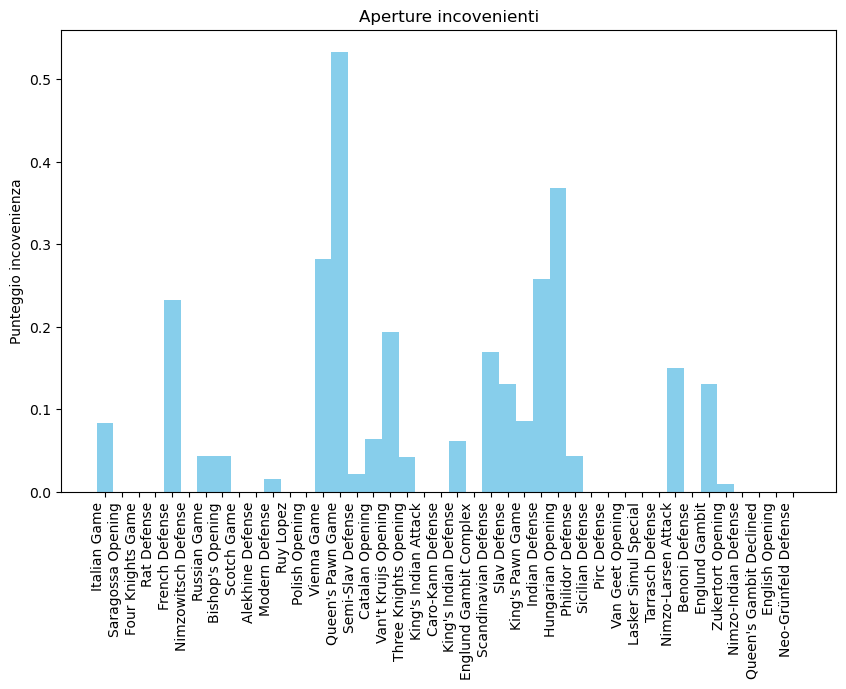

Peggiori 3 aperture:
 ["Queen's Pawn Game" 'Hungarian Opening' 'Vienna Game']


In [19]:
# calcoliamo il punteggio di convenienza
convenient_scores = np.clip(best_openings_freq - worst_openings_freq, 0, 1)
inconvenient_scores = np.clip(worst_openings_freq - best_openings_freq, 0, 1)

# troviamo il nome delle aperture più convenienti e non
n_openings_to_print = 3
indices_convenient_descending = np.argsort(convenient_scores)[::-1]
indices_inconvenient_descending = np.argsort(inconvenient_scores)[::-1]

plotter.plot_2d_histogram([common_openings, convenient_scores], title="Aperture convenienti", ylabel="Punteggio conveninza")
print("Migliori", n_openings_to_print, "aperture:\n", common_openings[indices_convenient_descending[:n_openings_to_print]])

plotter.plot_2d_histogram([common_openings, inconvenient_scores], title="Aperture incovenienti", ylabel="Punteggio incovenienza")
print("Peggiori", n_openings_to_print, "aperture:\n", common_openings[indices_inconvenient_descending[:n_openings_to_print]])



Un'analisi affascinante riguarda l'individuazione di aperture utilizzate con una certa frequenza in entrambe le categorie di partite vincenti e meno favorevoli. Tale ricerca risulta intrigante in quanto suggerisce la presenza di aperture che, nonostante la loro scelta, non necessariamente determinano il risultato di una partita. Questo fenomeno potrebbe indicare la presenza di aperture versatili, capaci di adattarsi a una varietà di contesti di gioco e sfidare l'idea che la scelta di un'apertura possa essere il fattore decisivo per il successo o l'insuccesso in una partita.

In [20]:
percent = 0.5

common_indices = np.array([])
indexes_best = np.where(best_openings_freq >= percent)
indexes_worst = np.where(worst_openings_freq >= percent)
# preniamo gli indici in comune
common_indices = np.intersect1d(indexes_best, indexes_worst)
    
    
print("\n\nAperture usate nelle partite migliori e peggiori con una frequenza del", percent * 100, "%:", common_openings[common_indices])



Aperture usate nelle partite migliori e peggiori con una frequenza del 50.0 %: ['Sicilian Defense' 'Zukertort Opening']


Qui di seguito si può vedere l'istogramma 3D delle aperture catalogate per categoria. Basta aggiungere <b>highlight_categories=["categoria"]</b> per evidenziare le categorie che si vuole analizzare

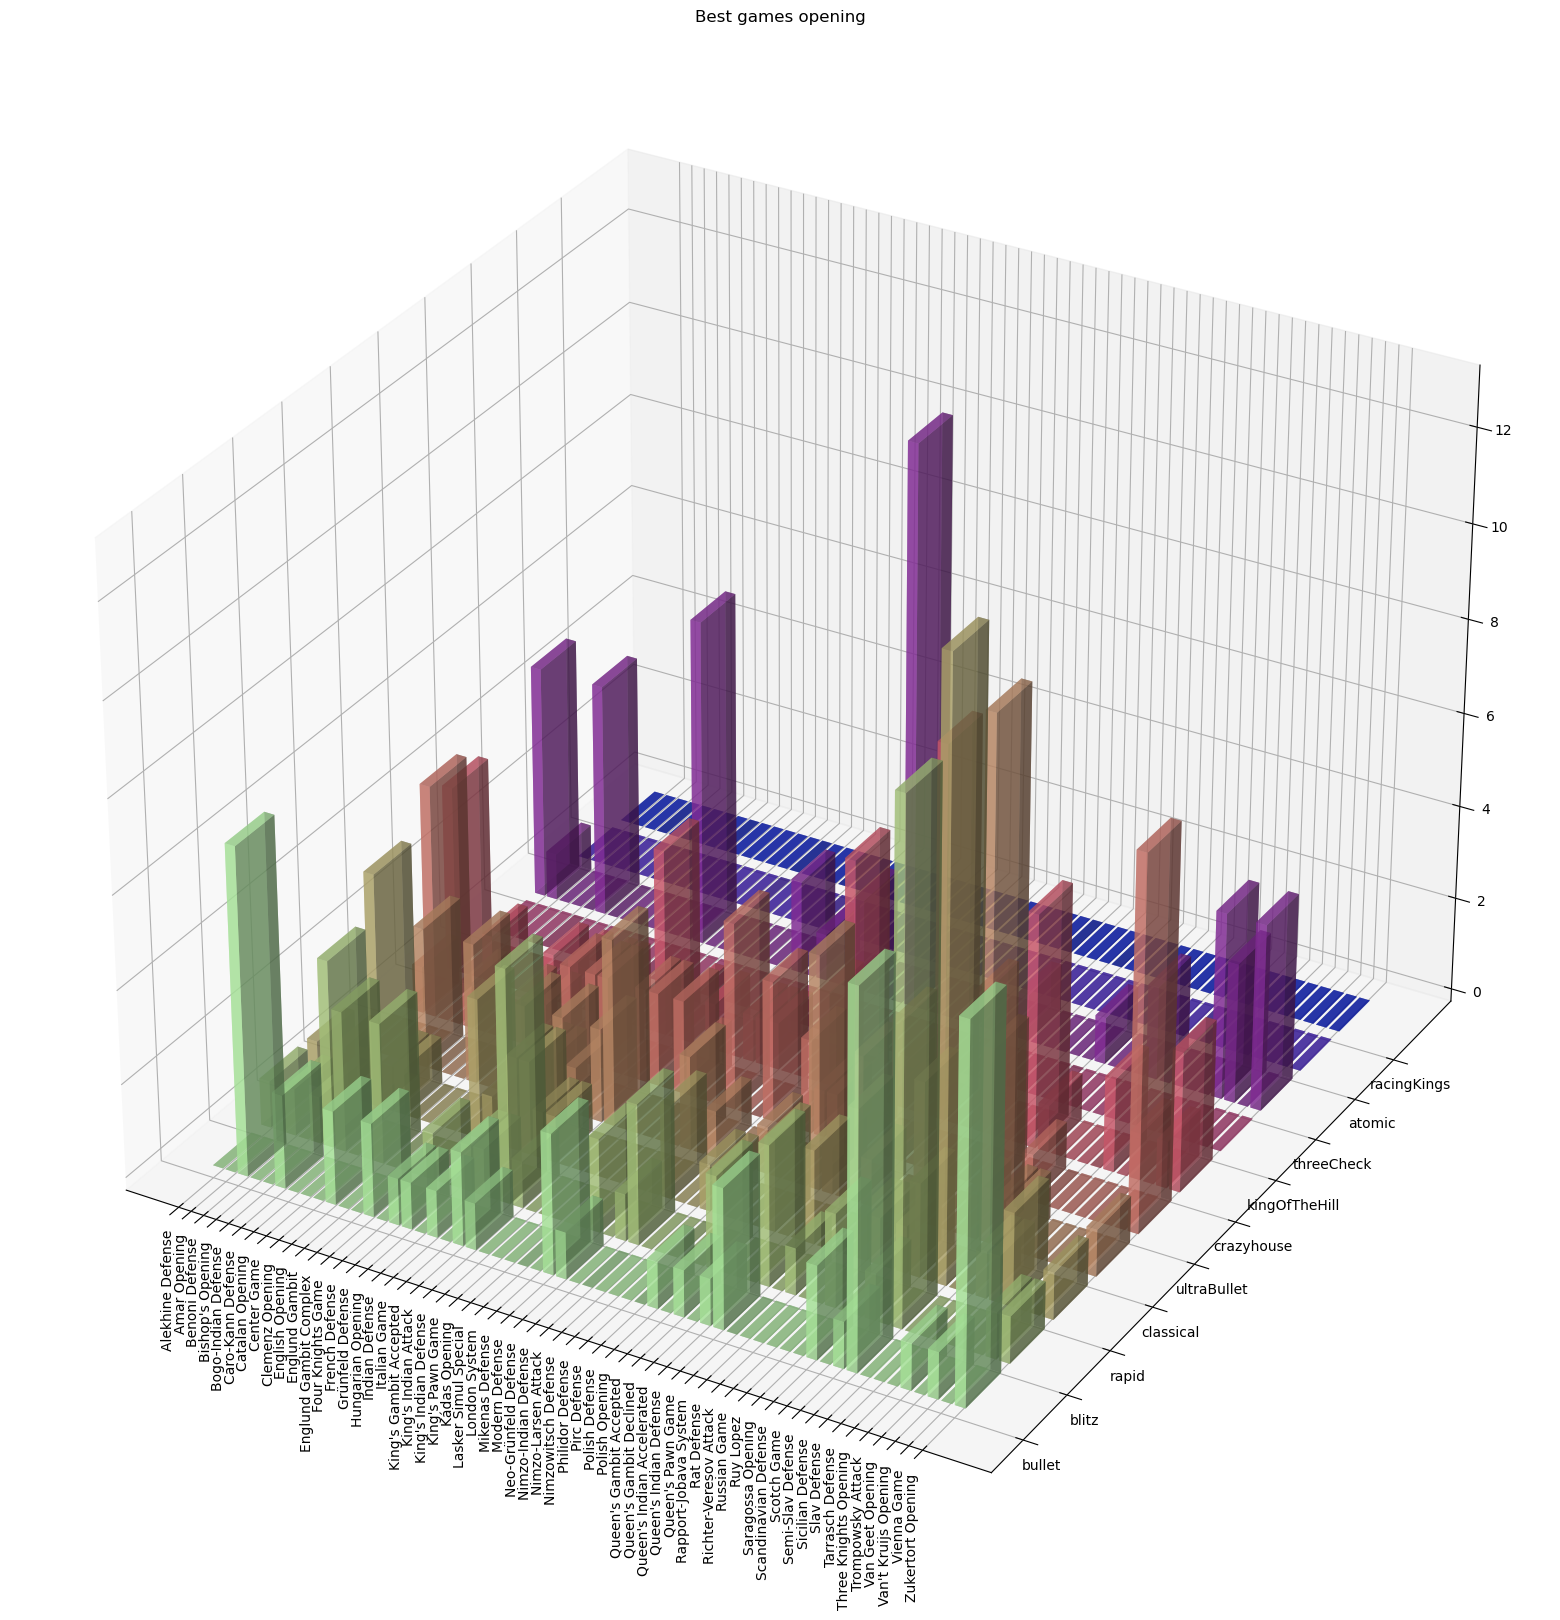

In [21]:
#highlight_categories
plotter.plot_3d_histogram(best_openings_by_category, title='Best games opening')

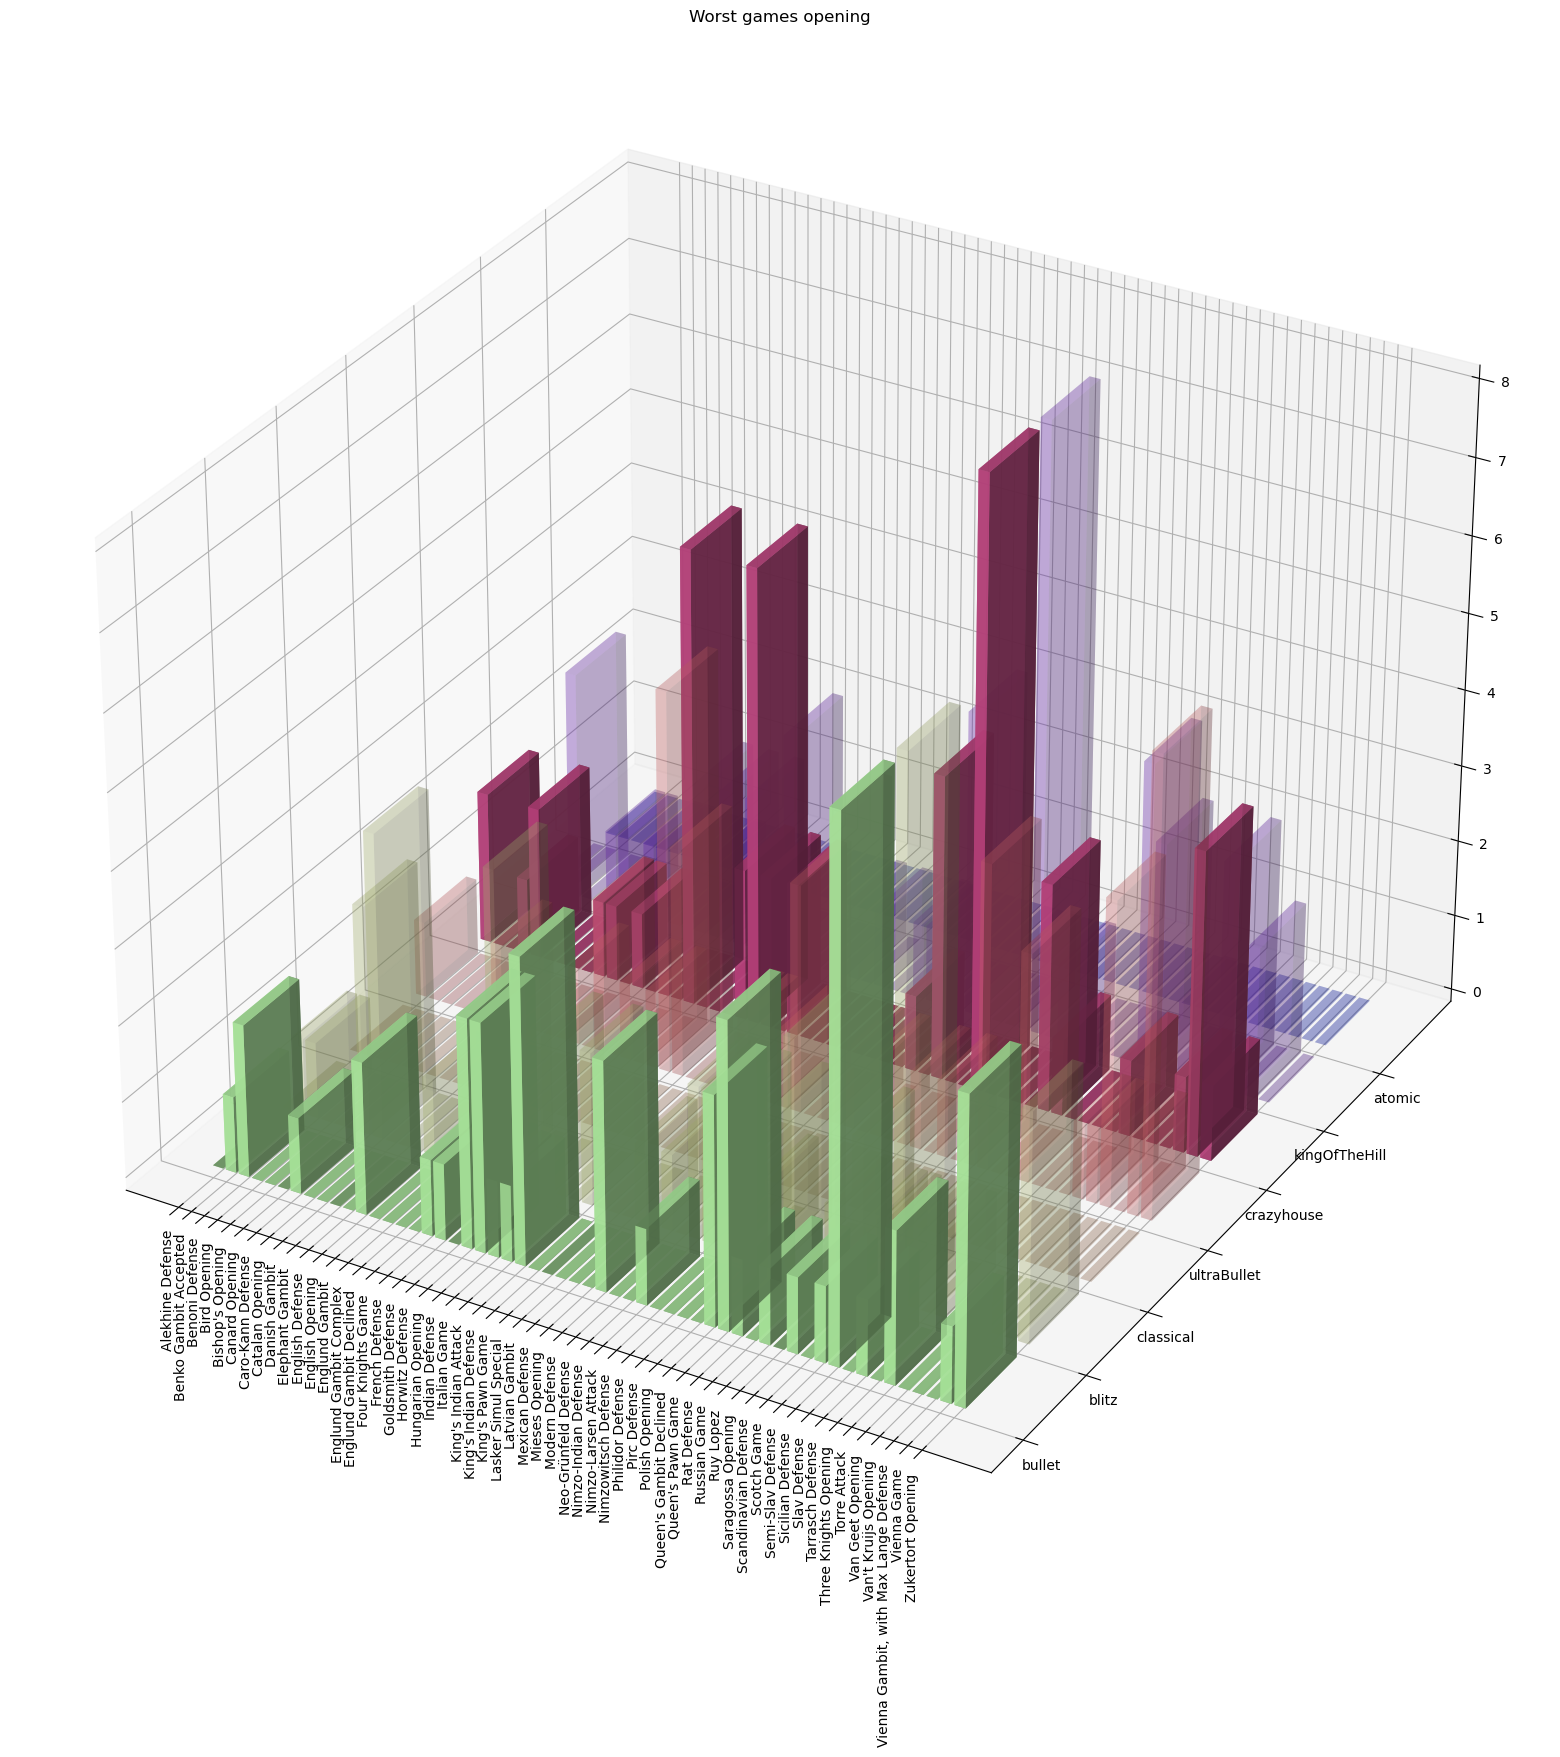

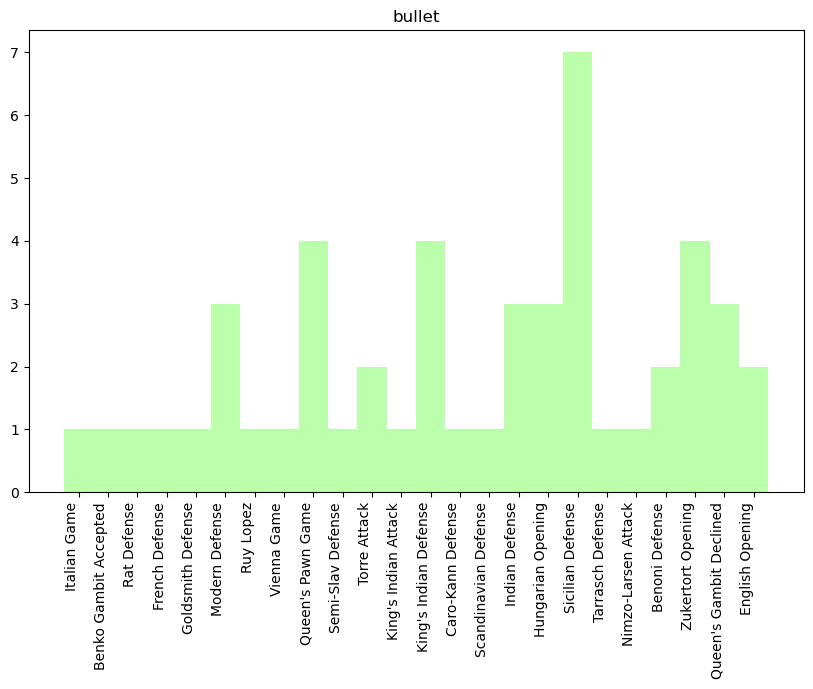

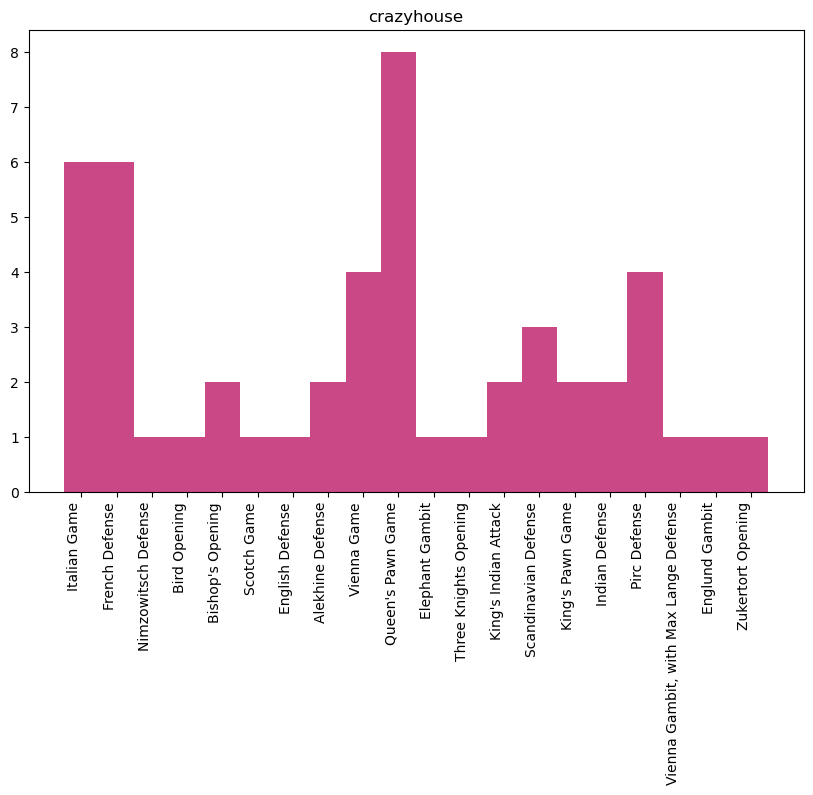

In [22]:
plotter.plot_3d_histogram(worst_openings_by_category, title='Worst games opening', highlight_categories=["bullet", "crazyhouse"])

# Analisi punteggio di una partita

Il nostro obiettivo principale è esaminare l'evoluzione delle valutazioni nelle partite vinte sia dal bianco che dal nero. In questo contesto, un punteggio più alto indica un vantaggio per il bianco, mentre un punteggio più basso suggerisce un vantaggio per il nero.

Utilizzeremo i dati raccolti e preparati fino a questo punto per analizzare le dinamiche delle valutazioni durante le partite vittoriose, distinguendo chiaramente tra il bianco e il nero.

L'obiettivo finale sarà determinare un punteggio soglia, al di sopra del quale possiamo affermare che un giocatore ha virtualmente vinto la partita con un livello di significatività del 95%.

Si può notare che sono presenti due sezioni:

### itestazione: 
presenta i dettagli su chi sta giocando la partita, ad esempio:
- data
- ID partita
- risultato finale
- nome dell'apertura
### corpo della partita:
segue un pattern ricorrente, ad esempio:

1\. e4 { [%eval 0.0] [%clk 0:00:30] } 1... e6 { [%eval 0.13] [%clk 0:00:30] }


- 1\. indica la prima mossa della partita da parte del bianco
- e4 indica che il bianco ha mosso il pedone in e4
- [%eval 0.0] indica il punteggio momentaneo
- [%clk 0:00:30] indica il tempo rimanente nel formato h:mm:ss
- 1... indica la prima mossa della partita da parte del nero
- e6 indica che il nero ha mosso il pedone in e6
- [%eval 0.13] indica il punteggio momentaneo
- [%clk 0:00:30] indica il tempo rimanente nel formato h:mm:ss

quindi una partita è un insieme di elementi di questo tipo.

### Problemi principali

Le partite possono concludersi con una vittoria, un pareggio o, in alternativa, il termine del tempo a disposizione di uno dei giocatori, senza necessariamente raggiungere uno scacco matto. Nell'ambito dell'analisi delle partite, ci concentreremo specificamente su quelle che sono state vinte attraverso uno scacco matto.

Dall'esame del dataset, ho notato che non tutte le partite includono informazioni dettagliate sul tempo residuo in ogni momento della partita. Questa mancanza di dati rende più complesso il processo di pulizia del dataset, poiché non siamo in grado di determinare se una partita è stata vinta a causa del termine del tempo dell'avversario.

Un'idea potrebbe essere quella di escludere dalla considerazione tutte le partite vinte da un giocatore se il punteggio finale è prossimo allo zero o nettamente lontano dal loro vantaggio abituale. Ad esempio, se il bianco ha vinto la partita, ma l'ultimo punteggio è negativo, potrebbe indicare che in realtà il nero aveva il vantaggio ma ha esaurito il tempo a disposizione, determinando la vittoria del bianco.

Un ulteriore ostacolo riscontrato è la notevole variabilità del punteggio ad ogni istante della partita, con la complicazione aggiuntiva che non tutti i giochi presentano gli stessi range di valori. Di conseguenza, risulta auspicabile procedere con una normalizzazione dei punteggi per ciascuna partita.

Questa normalizzazione ci consentirà di omogeneizzare i punteggi, mitigando le differenze tra i diversi intervalli di variabilità e facilitando così l'analisi complessiva del dataset. Tale approccio renderà più agevole identificare e interpretare le dinamiche della partita, garantendo una rappresentazione più accurata e confrontabile dei punteggi per ciascun incontro.

In [23]:
# funzione per validare una partita. Essa è valida se il punteggio dell'ultima mossa è
# in accordo con il vincitore della partita. Ad esempio se il bianco ha vinto la partita
# non ha senso che l'ultimo punteggio sia negativo (probabilmente è scaduto il timer). 
# Inoltre l'ultimo punteggio del giocatore deve essere sopra una derminata soglia.
def is_valid_game(evals, winner, min_eval = 0):
    # un giocatore bianco non vince avendo un punteggio negativo
    if(winner == "White" and evals[-1] < 0):
        return False
    # un giocatore nero non vince avendo punteggio positivo
    if(winner == "Black" and evals[-1] > 0):
        return False
    return np.abs(evals[-1]) > min_eval

Analizziamo ora la media delle partite e plottiamo la loro distribuzione

In [24]:
# questa funzione legge tutte le partite da una cartella, controlla che siano valide e ritorna un dizionario
# con le coppia (media, frequenza)
def process_directory(directory_path, validity_check=None):
    mean_count = {}
    
    with os.scandir(directory_path) as entries:
        for entry in entries:
            if entry.is_file():
                file_path = os.path.join(directory_path, entry.name)
                
                with open(file_path, 'r') as file:
                    game_txt = file.read()
                    game = Game(game_txt)
                    
                    evals = np.array(game.get_evals())
                    
                    if validity_check is not None and not validity_check(evals, game):
                        continue
                    
                    mean = np.round(np.mean(evals[1:]), 2)
                    mean_count[mean] = mean_count.get(mean, 0) + 1
    
    return mean_count

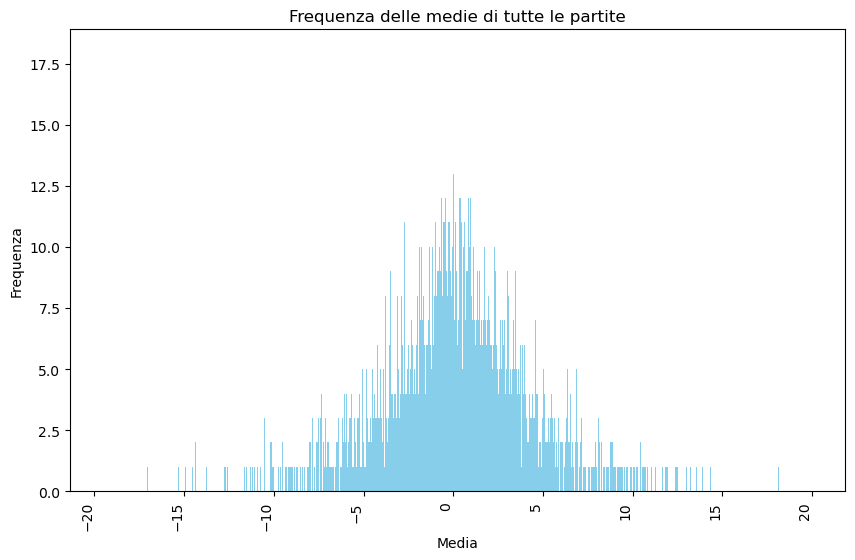

In [25]:
def checker(evals, game):
    if(not is_valid_game(evals, game.get_winner(), 0.2)):
        return False
    return True

means = process_directory('./downloaded_games', checker)

values = list(means.keys())
frequencies = list(means.values())


plotter.plot_2d_histogram([values, frequencies], title='Frequenza delle medie di tutte le partite', xlabel='Media', ylabel='Frequenza', color = 'skyblue', width=0.02)

Considerando tutte le partite del dataset si nota una certa simmetria nell'istogramma, ciò potrebbe suggerire che il punteggio soglia per il bianco e per il nero differirà per il segno, ma in valore assoluto sarà pressochè lo stesso.

Plottiamo l'istogramma delle medie delle partite vinte dal bianco e dal nero.

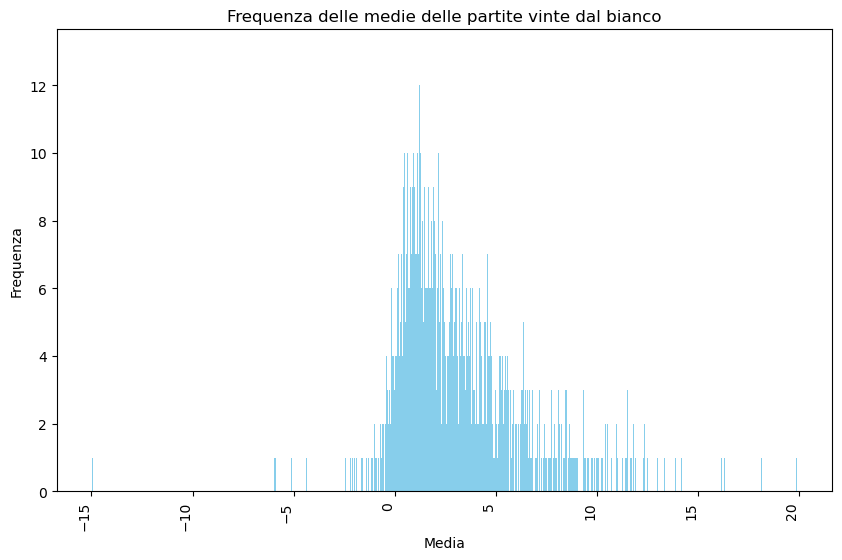

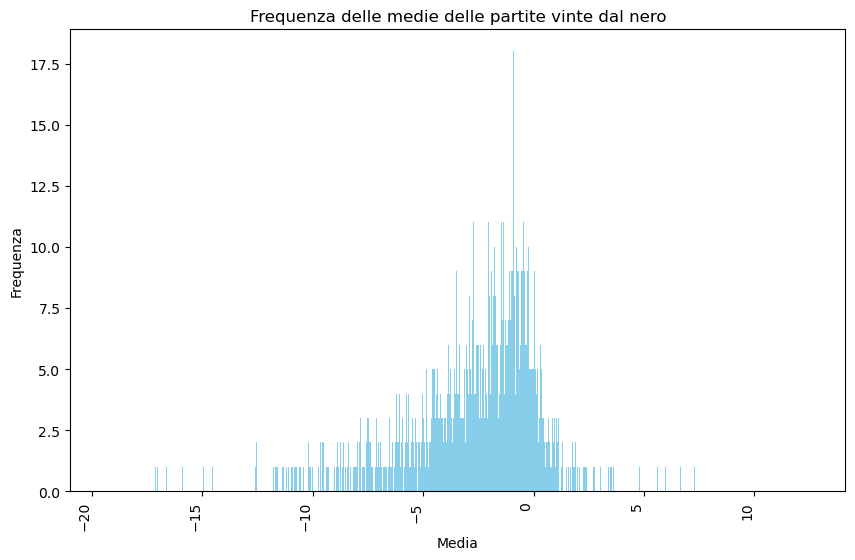

In [26]:
def checker(evals, game):
    if(game.get_winner() == "Black"):
        return False
    if(not is_valid_game(evals, game.get_winner(), 0.2)):
        return False
    return True

means_white = process_directory('./downloaded_games', checker)

values_white = np.array(list(means_white.keys()))
frequencies_white = np.array(list(means_white.values()))

plotter.plot_2d_histogram([values_white, frequencies_white], title='Frequenza delle medie delle partite vinte dal bianco', xlabel='Media', ylabel='Frequenza', color = 'skyblue', width=0.02)

def checker(evals, game):
    if(game.get_winner() == "White"):
        return False
    if(not is_valid_game(evals, game.get_winner(), 0.2)):
        return False
    return True

means_black = process_directory('./downloaded_games', checker)

values_black = np.array(list(means_black.keys()))
frequencies_black = np.array(list(means_black.values()))

plotter.plot_2d_histogram([values_black, frequencies_black], title='Frequenza delle medie delle partite vinte dal nero', xlabel='Media', ylabel='Frequenza', color = 'skyblue', width=0.02)



Si osserva con attenzione una particolare caratteristica nelle medie dei punteggi relative alle partite vinte dal giocatore bianco: la presenza di valori negativi. Tale fenomeno potrebbe indicare situazioni in cui il giocatore nero, pur detenendo un vantaggio evidente, abbia compiuto una mossa sbagliata, consentendo al giocatore bianco di invertire le sorti della partita e conseguentemente ottenere la vittoria.

L'approccio analitico a questa tematica si prefigge di esplorare in maniera approfondita la dinamica di gioco nelle partite tra giocatori dilettanti. Questo sarà effettuato considerando attentamente la possibilità di uno squilibrio tattico che potrebbe insorgere durante le partite, riflettendo la natura più informale e, talvolta, imprevedibile di tali incontri.

Successivamente sarà condotta un'analisi concentrandoci sui casi in cui le medie di punteggio riflettono coerentemente la dinamica della partita. Questo aspetto riflette le partite disputate da giocatori professionisti, i quali, data la loro esperienza e abilità, manifestano una maggiore coerenza nei risultati in relazione all'andamento della partita. In questo contesto, sarà valutato il basso rischio di rimonta da parte dell'avversario quando un giocatore professionista detiene un vantaggio considerevole.

Determiniamo la media dei punteggi minima che non è stata superata nel 95% delle partite vinte dal giocatore bianco. In altre parole, sto cercando il valore soglia al di sotto del quale si trova il 95% delle medie dei punteggi delle partite vinte dal bianco.

In [27]:
all_means_white = repeat_keys_as_array(means_white)

# trovo il media minimo che non è stata superata nel 95% delle partite vinte dal bianco
threshold_white = np.percentile(all_means_white, 95)
print("Soglia media per vincere considerando tutte le partite(Bianco):", threshold_white)

Soglia media per vincere considerando tutte le partite(Bianco): 8.57


Determiniamo la media dei punteggi minima che non è stata superata nel 95% delle partite vinte dal giocatore nero. In altre parole, sto cercando il valore soglia al di sopra del quale si trova il 95% delle medie dei punteggi delle partite vinte dal nero.

In [28]:
all_means_black = repeat_keys_as_array(means_black)

# trovo il media massima che non è stato superata nel 95% delle partite vinte dal nero
threshold_black = np.percentile(all_means_black, 5)
print("Soglia media per vincere considerando tutte le partite(Nero):", threshold_black)

Soglia media per vincere considerando tutte le partite(Nero): -8.125


Come dedotto in precedenza questa soglia differisce per il segno ma non cambia molto dal bianco o dal nero. 

Effettuamo di nuovo la stessa analisi andando a non considerare le medie di partite dove c'è stato una rimonta da parte del giocatore avversario.

In [29]:
threshold_white = np.percentile(all_means_white[all_means_white > 0], 95)
print("Soglia media per vincere considerando le partite con le medie in accordo con il vincitore(Bianco):", threshold_white)

Soglia media per vincere considerando le partite con le medie in accordo con il vincitore(Bianco): 8.775999999999998


In [30]:
threshold_black = np.percentile(all_means_black[all_means_black < 0], 5)
print("Soglia media per vincere considerando le partite con le medie in accordo con il vincitore(Nero):", threshold_black)

Soglia media per vincere considerando le partite con le medie in accordo con il vincitore(Nero): -8.574


# Conclusioni

L'analisi condotta sulle aperture e i punteggi delle partite di scacchi ha fornito risultati coerenti e significativi, riflettendo aspetti cruciali del gioco degli scacchi. Le seguenti conclusioni possono essere tratte:

- Efficacia delle Aperture: I risultati evidenziano che le aperture considerate più efficaci sono quelle universalmente rinomate nel contesto degli scacchi. Questo risulta in sintonia con le aspettative, poiché chi possiede anche una minima conoscenza degli scacchi è consapevole dell'importanza e della validità di tali aperture.
- Punteggio Medio di Soglia: La similitudine nei punteggi medi di soglia per entrambi i giocatori riflette un equilibrio nelle partite di scacchi. Questo dato suggerisce che, in generale, le partite sono competitive e possono essere determinate da fattori strategici e tattici piuttosto che da squilibri intrinseci tra i giocatori.

È interessante osservare che il punteggio in modulo risulta più elevato per il giocatore bianco, suggerendo che, nonostante inizi per primo, non gode di un vantaggio significativo nella partita. Si nota che il giocatore nero ha una soglia di punteggio minore da superare rispetto al giocatore bianco per ottenere una probabilità del 95% di vittoria.

Per un'analisi più approfondita, sarebbe stimolante esaminare la variazione delle soglie dei punteggi considerando intervalli di tempo specifici. L'approccio attuale si basa su una media dei punteggi delle partite degli scacchi, ma è da notare che le partite differiscono per il numero totale di mosse effettuate. Pertanto, una prospettiva futura potrebbe concentrarsi sulla determinazione delle soglie medie dei punteggi in relazione al numero di mosse effettuate dai giocatori in un determinato momento della partita.

Questa riflessione potrebbe contribuire a una comprensione più approfondita delle dinamiche di gioco, considerando la lunghezza e lo sviluppo temporale delle partite degli scacchi.

In definitiva, l'analisi fornisce un quadro comprensivo e realistico del panorama delle aperture e dei risultati delle partite di scacchi, offrendo un'importante prospettiva per giocatori, appassionati e studiosi degli scacchi.

La prossima volta che farete una partita, tenete traccia della media dei punteggi che vi sono assegnati dal computer e provate a superare la media dell'8, così facendo avrete la partita in pugno!